<a href="https://colab.research.google.com/github/deepskies/sbi-lensed-qso/blob/dev-clean/NIPS_paper/Neural_networks/Inference/Performance_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Sep 25 13:29:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os, sys

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
mpl.style.use('default')

import torch
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True) # otherwise fails to compute cholesky due to bad correlation matrix precision
config.update("jax_debug_nans", True)


import os
# more than 50% is not needed for Tesla P100
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50'


# on tesla P100 the speed of samping is much much faster

#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)



import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


FS = 18 # fontsize


!pip install einops --quiet

# Dataset

In [4]:
import torch.multiprocessing as multiprocessing
multiprocessing.set_start_method('spawn')

## Labels

In [5]:
tau_rng = np.random.default_rng(78)
rho_rng = np.random.default_rng(18)

rho_bounds = np.array([0.55,10])
#log_tau_bounds = np.array([1.68,3.93])
#log_tau_params = np.array([2.73,0.3])
log_tau_bounds = np.array([1.05,2.76]) # from 10 days (third minimal in the paper, to 580 days, which is red noise for 10 years)

rho_distribution=scipy.stats.uniform(rho_bounds[0],rho_bounds[1]-rho_bounds[0])
#log_tau_distribution = scipy.stats.truncnorm(*(log_tau_bounds-log_tau_params[0])/log_tau_params[1],*log_tau_params)
log_tau_distribution = scipy.stats.uniform(log_tau_bounds[0],log_tau_bounds[1]-log_tau_bounds[0])

num_labels = 300000
rho_samples = rho_distribution.rvs(size=num_labels,random_state=rho_rng)
log_tau_samples = log_tau_distribution.rvs(size=num_labels,random_state=tau_rng)

labels_data = np.array([np.power(10, log_tau_samples),rho_samples]).T

duration = 10
# additionally sample 10 years for saturation

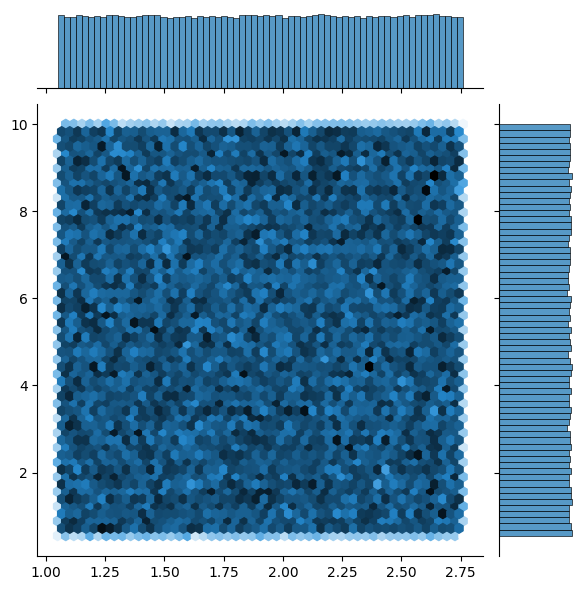

In [5]:
sns.jointplot(x=log_tau_samples,y=rho_samples,kind='hex')

## RDRW dataset class

In [6]:
from functools import partial
from scipy.interpolate import BSpline

@jax.jit
def split_six_keys(key):
  return jax.random.split(key,6)

class RDRW():

    def __init__(self,softening=1e-10,diagonal_softening=1e-8):

        self.softening = softening
        self.diagonal_softening = diagonal_softening


    def Power_spectrum(self,frequencies,Correlation_time,Reverberation_time,Variance = 1.,grid_step=1.):

        Normalisation = Variance**2 * (Correlation_time + Reverberation_time) /grid_step

        omega = 2* np.pi* frequencies

        Tau_factor = (1+omega**2 * Correlation_time**2)
        Rho_factor = (1+omega**2 * Reverberation_time**2)

        return Normalisation/Tau_factor/Rho_factor + self.diagonal_softening


    def RDRW_covariance(self,abs_time_difference, Correlation_time, Reverberation_time, Variance = 1.):

        Tau_ratio =  abs_time_difference / Correlation_time
        Rho_ratio = abs_time_difference / (Reverberation_time + self.softening)

        # caps of exponential factors to facilitate Cholesky decomposition
        #Tau_dependence = (Tau_ratio< -np.log(self.softening)) * jnp.exp(-Tau_ratio)
        #Rho_dependence = (Rho_ratio< -np.log(self.softening)) * jnp.exp(-Rho_ratio)

        Tau_dependence = jnp.exp(-Tau_ratio)
        Rho_dependence = jnp.exp(-Rho_ratio)

        Normalisation = 1. / (Correlation_time  - Reverberation_time)

        Time_dependence = Correlation_time * Tau_dependence - Reverberation_time * Rho_dependence

        return Variance*Normalisation * Time_dependence


    def conditional_distribution(self,desired_times,time_array, values_array,
            Correlation_time, Reverberation_time, Variance = 1., Mean = 0.):

        time_difference = desired_times[None,:] - time_array[:,None]

        Mutual_Correlations = self.RDRW_covariance(jnp.abs(time_difference),Correlation_time,Reverberation_time)

        Reference_Corr_matrix = self.RDRW_covariance(jnp.abs(time_array[None,:] - time_array[:,None]),Correlation_time,Reverberation_time)   + np.eye(len(time_array)) * self.diagonal_softening

        Reference_Cholesky = jax.scipy.linalg.cholesky(Reference_Corr_matrix, lower=True, overwrite_a=True)

        # Mean prediction
        alpha = jax.scipy.linalg.cho_solve((Reference_Cholesky, True), values_array)

        conditional_Mean = Mean + Mutual_Correlations.T @ alpha
        # f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)

        Mutual_Corr_matrix = jax.scipy.linalg.solve_triangular(Reference_Cholesky,Mutual_Correlations,lower=True,check_finite=False)

        desired_time_difference = desired_times[None,:] - desired_times[:,None]
        self_Correlation_matrix = self.RDRW_covariance(jnp.abs(desired_time_difference),Correlation_time,Reverberation_time)

        conditional_Covariance_matrix = Variance * (self_Correlation_matrix -  Mutual_Corr_matrix.T @ Mutual_Corr_matrix)

        return conditional_Mean,conditional_Covariance_matrix

class RDRW_simulator(RDRW):

    def __init__(self,duration = 10, Saturation_time=10, grid_step = 4, random_seed = 7, softening=1e-10,diagonal_softening=1e-6):
        super().__init__(softening,diagonal_softening)

        if Saturation_time is None:
          # so we have a frequency on duration time
          Saturation_time = duration

        # Saturation is 22 years because above it would be just a random walk np.power(10,3.2)/365*2*np.pi

        self.duration = duration
        self.Saturation_time = Saturation_time

        
        self.length = 2*round((duration+Saturation_time)*365/grid_step/2)
        self.grid_step = grid_step/365

        self.frequencies = np.fft.rfftfreq(self.length,grid_step/365)
        self.grid = np.arange(0,self.length)*grid_step/365
        self.Saturation_offset = 2*round((Saturation_time)*365/grid_step/2)

        self.rng_key = jax.random.PRNGKey(random_seed)

        self.cadence_logits, self.mean_cadence = self.cadence_params()
        # 1.1 to enure that it reaches 5 years
        self._time_size = round(duration*365 / self.mean_cadence)


        num_ref_points = 365
        step = 1 / num_ref_points
        self.query = np.linspace(step/2, 1 - step/2, num_ref_points,dtype=np.float32)
        self.full_query = np.repeat([self.query],self.duration,axis=0) + np.arange(self.duration)[:,None]

        self.simulator = self.get_simulator()


    def cadence_params(self,Day_amplitude = 0.7338, Poisson_scale = 4):
        # default values from high cadence observations in cosmograil dataset

        def cadence_pdf(x,A,const):
            return A*np.exp(-(x-1)/Poisson_scale)+const*(x==1)

        cadences = np.arange(1,25)
        probabilities = cadence_pdf(cadences,*[1.,Day_amplitude])
        probabilities/=probabilities.sum()

        logits = np.log(probabilities)

        math_expectation = (cadences*probabilities).sum()

        return logits,math_expectation

    def simulate_observation_times(self,key_cadence,key_night_times):

        exponential_cadences = jax.random.categorical(key_cadence, self.cadence_logits,
                                          shape=(self._time_size,))

        # to not overfit global shift
        start_point = exponential_cadences[0]
        # 1 day + possible poisson gaps
        cadences = 1+exponential_cadences[1:]

        # variation of obs time within night
        #night_times = jnp.clip(jax.random.laplace(key_night_times,shape=(self._time_size,)) * 0.055,-0.4,0.4)
        night_times = jax.random.uniform(key_night_times,shape=(self._time_size,),minval=-5/24,maxval=5/24)
        time_array = start_point + jnp.append(np.zeros(1),jnp.cumsum(cadences)) + night_times

        return time_array / 365

    def simulate_GP_on_regular_grid(self,Correlation_time,Reverberation_time,rng_key_magnitude):

        power = self.Power_spectrum(self.frequencies[1:],Correlation_time,Reverberation_time,grid_step=self.grid_step)

        noise = jax.random.normal(rng_key_magnitude,shape=(self.length,)).reshape(2,-1)
        phases = (noise*np.array([1.+0j,0.+1j])[:,None]).sum(axis=0)

        Fourier_image = jnp.append(np.zeros(1),jnp.sqrt(power)*phases)

        return jnp.fft.irfft(Fourier_image,norm='ortho')

    def simulate_GP_on_irregular_grid(self,Correlation_time,Reverberation_time,rng_key_regular_magnitude, rng_key_irregular_magnitude , rng_key_cadence, rng_key_night):

        regular_GP = self.simulate_GP_on_regular_grid(Correlation_time,Reverberation_time,rng_key_regular_magnitude)

        irregular_time_array = self.simulate_observation_times(rng_key_cadence,rng_key_night)

        local_grid = (self.grid - self.Saturation_time)[self.Saturation_offset:]
        local_regular_GP = regular_GP[self.Saturation_offset:]
        irregular_Mean, irregular_Covariance_matrix = self.conditional_distribution(irregular_time_array,local_grid,local_regular_GP,Correlation_time,Reverberation_time)

        irregular_Cholesky = jax.scipy.linalg.cholesky(irregular_Covariance_matrix + np.eye(self._time_size) * self.diagonal_softening, lower=True, overwrite_a=True)

        noise = jax.random.normal(rng_key_irregular_magnitude,shape=(self._time_size,))

        irregular_GP = irregular_Mean + irregular_Cholesky @ noise

        return irregular_time_array,irregular_GP,irregular_Mean,irregular_Covariance_matrix,regular_GP

    def sample_gaps(self,key_width,key_shift,shape):
        duration_params = np.array([135,25])
        duration_bounds = np.array([80,220])
        duration_normalised_bounds = (duration_bounds - duration_params[0])/duration_params[1]
        widths = jax.random.truncated_normal(key_width,*duration_normalised_bounds,shape=shape)*duration_params[1]+duration_params[0]

        middle_shifts_scale = 12
        middle_shifts_bounds = np.array([-20,20])
        middle_shifts_normalised_bounds = middle_shifts_bounds/middle_shifts_scale
        middle_shifts = jax.random.truncated_normal(key_shift,*middle_shifts_normalised_bounds,shape=shape)*middle_shifts_scale

        return middle_shifts,widths

    def sample_nogaps_masks(self,time_array,grid_time,key_width,key_shift):

        gap_middle_shifts,gaps_widths = self.sample_gaps(key_width,key_shift,(self.duration+1,))

        # gap middle shift for selected year and
        gaps_starts = (gap_middle_shifts - gaps_widths/2)/365 + np.arange(self.duration+1)
        gaps_ends = (gap_middle_shifts + gaps_widths/2)/365 + np.arange(self.duration+1)

        nogaps_masks = (time_array[None,:] > gaps_ends[:-1,None]) & (time_array[None,:] < gaps_starts[1:,None])

        test_nogaps_masks = (grid_time[None,:] > gaps_ends[:-1,None]) & (grid_time[None,:] < gaps_starts[1:,None])

        return  nogaps_masks.sum(0).astype(bool),test_nogaps_masks.sum(0).astype(bool)

    def sample_irregular_time_mag_mask(self,Correlation_time,Reverberation_time,
                             rng_key_regular_magnitude, rng_key_irregular_magnitude ,
                             rng_key_cadence, rng_key_night,
                             rng_gap_key_width,rng_gap_key_shift):


        regular_GP = self.simulate_GP_on_regular_grid(Correlation_time,Reverberation_time,rng_key_regular_magnitude)

        irregular_time_array = self.simulate_observation_times(rng_key_cadence,rng_key_night)

        local_grid = (self.grid - self.Saturation_time)[self.Saturation_offset:]
        local_regular_GP = regular_GP[self.Saturation_offset:]
        irregular_Mean, irregular_Covariance_matrix = self.conditional_distribution(irregular_time_array,local_grid,local_regular_GP,Correlation_time,Reverberation_time)

        irregular_Cholesky = jax.scipy.linalg.cholesky(irregular_Covariance_matrix + np.eye(self._time_size) * self.diagonal_softening, lower=True, overwrite_a=True)

        noise = jax.random.normal(rng_key_irregular_magnitude,shape=(self._time_size,))

        irregular_GP = irregular_Mean + irregular_Cholesky @ noise


        nogaps_masks,test_nogaps_masks = self.sample_nogaps_masks(irregular_time_array,local_grid,rng_gap_key_width,rng_gap_key_shift)

        return irregular_time_array,irregular_GP,nogaps_masks,local_grid,local_regular_GP,test_nogaps_masks

    def get_simulator(self):

      @partial(jax.jit,backend='gpu')
      def simulator(Correlation_time,Reverberation_time,
                             rng_key):
        
        #self.rng_key, rng_key_regular_magnitude, rng_key_irregular_magnitude,rng_key_cadence, rng_key_night,rng_gap_key_width,rng_gap_key_shift= 
        #self.split_seven_keys(self.rng_key)
        rng_new_key, rng_key_regular_magnitude, rng_key_irregular_magnitude ,rng_key_cadence, rng_key_night, rng_gap_key_width,rng_gap_key_shift = jax.random.split(rng_key,7)

        return rng_new_key, self.sample_irregular_time_mag_mask(Correlation_time,Reverberation_time,
                             rng_key_regular_magnitude, rng_key_irregular_magnitude ,
                             rng_key_cadence, rng_key_night,
                             rng_gap_key_width,rng_gap_key_shift)

      return simulator


    @partial(jax.jit,static_argnums=(0,), backend='cpu')
    def split_seven_keys(self,key):
        return jax.random.split(key,7)

    def sample_light_curve(self,Correlation_time,Reverberation_time):


        #self.rng_key, rng_key_regular_magnitude, rng_key_irregular_magnitude,rng_key_cadence, rng_key_night,rng_gap_key_width,rng_gap_key_shift= self.split_seven_keys(self.rng_key)

        self.rng_key, (time_array,magnitude,nogaps_masks,test_time_array,test_magnitude,test_nogaps_masks) = self.simulator(Correlation_time/365,Reverberation_time/365,
                                                        self.rng_key)

        return np.array(time_array),np.array(magnitude),np.array(nogaps_masks),np.array(test_time_array),np.array(test_magnitude),np.array(test_nogaps_masks)


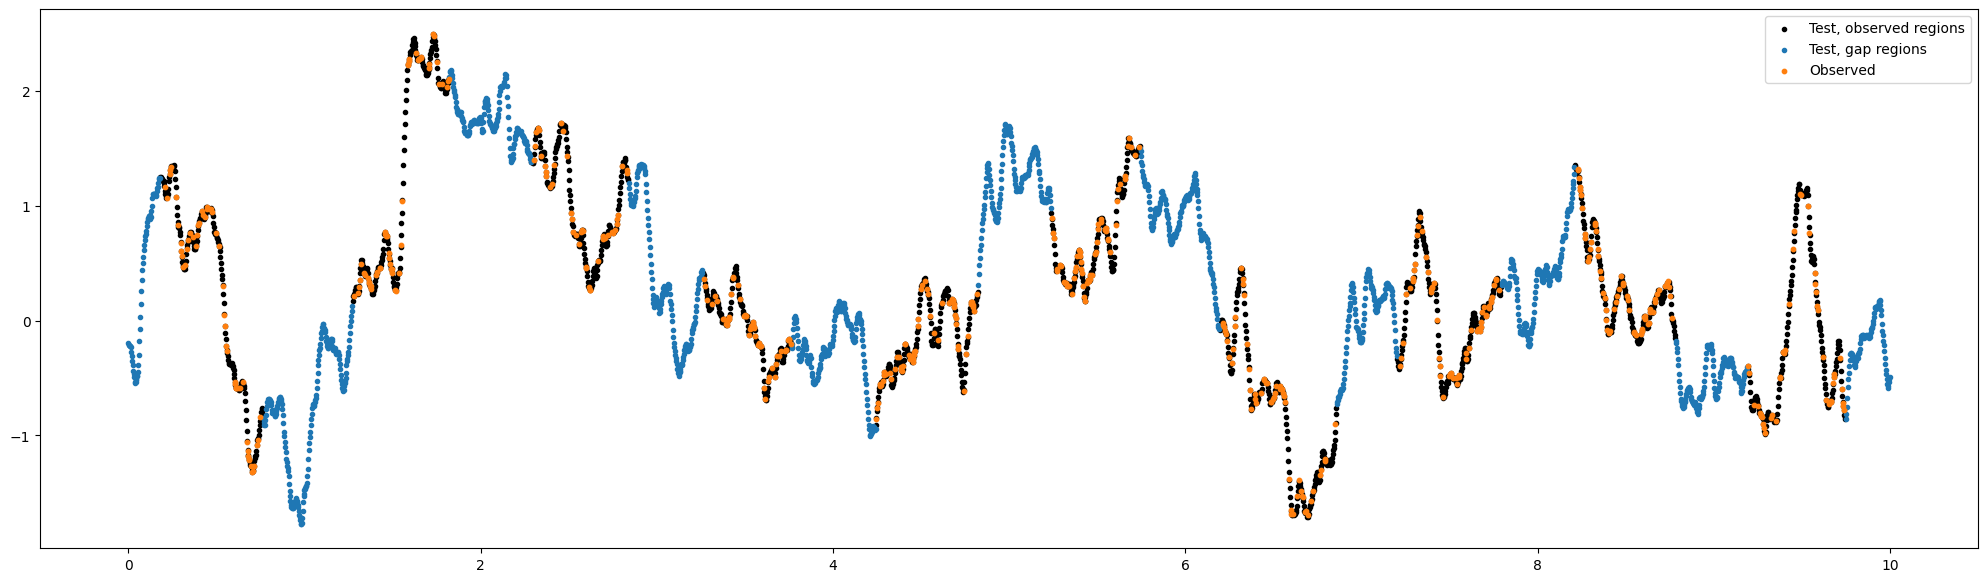

In [7]:
simulator = RDRW_simulator(grid_step=1)
time,magnitude,mask,test_time,test_magnitude,test_mask = simulator.sample_light_curve(*labels_data.mean(axis=0))
fig,ax = plt.subplots(figsize=(25,7))

plt.scatter(test_time[test_mask],test_magnitude[test_mask],color='k',marker='.',label='Test, observed regions')
plt.scatter(test_time[~test_mask],test_magnitude[~test_mask],color='C0',marker='.',label='Test, gap regions')
plt.scatter(time[mask],magnitude[mask],color='C1',label='Observed',s=10)

plt.legend()

## Observation dataset

In [7]:
import numpy as np
from scipy.interpolate import BSpline
from typing import Union


class Normalise:

    def __init__(self, light_curve_target_max: float = 1., light_curve_target_min: float = -1.):

        assert light_curve_target_max > light_curve_target_min

        self._light_curve_target_max=light_curve_target_max
        self._light_curve_target_min=light_curve_target_min

    def light_curve_normalisation(self,curve_max,curve_min,target_max = None, target_min = None):


        if target_max is None:
            target_max = self._light_curve_target_max
        if target_min is None:
            target_min = self._light_curve_target_min


        curve_norm_factor= (target_max - target_min) / (curve_max - curve_min + 1e-10)
        curve_norm_shift= target_min - curve_min * curve_norm_factor

        return curve_norm_factor,curve_norm_shift

    def normalise_light_curve(self,light_curve: np.ndarray,curve_norm_factor = None, curve_norm_shift = None):

        if (curve_norm_factor is None) and (curve_norm_shift is None):
            curve_norm_factor, curve_norm_shift = self.light_curve_normalisation(np.max(light_curve),np.min(light_curve))

        normalised_light_curve= light_curve * curve_norm_factor + curve_norm_shift

        return normalised_light_curve

    def normalise_label(self, label: Union[np.ndarray,list], curve_norm_factor: float, curve_norm_shift: float, time_factor = None):


        if time_factor is None:
            time_factor = self._time_norm

        # Mean normalised according to Light_curve.
        # Corr_length and t_lambda normalised according to time_array
        # SF^2 ~ Variance/corr_time hence it transforms like curve_norm_factor**2/time_norm_factor
        #label_norm_factors = np.array([curve_norm_factor, (curve_norm_factor ** 2) * time_factor,
        #                               1. / time_factor, 1. / time_factor])
        # we assume that there is SF^2 in label[1]
        label_norm_factors = np.array([curve_norm_factor, curve_norm_factor ** 2,
                                       1. / time_factor, 1. / time_factor])
        label_norm_shifts= np.array([curve_norm_shift, 0., 0., 0.])
        normalised_label = label * label_norm_factors + label_norm_shifts

        return normalised_label

In [9]:
from torch.utils.data import Dataset
class Train_Test_RDRW(Dataset):

  def __init__(self, RDRW_simulator,labels: np.ndarray,light_curve_norm=(1, -1)):

      super().__init__()

      assert len(labels) == 1  

      self.labels = labels
      self.RDRW_simulator = RDRW_simulator
      self.duration = self.RDRW_simulator.duration
      self.normalise_class = Normalise(*light_curve_norm)

      num_ref_points = 365
      step = 1 / num_ref_points
      self.query = np.linspace(step/2, 1 - step/2, num_ref_points,dtype=np.float32)
      self.full_query = np.repeat([self.query],self.duration,axis=0) + np.arange(self.duration)[:,None]
  
  def interpolate(self,time,light,padding='zeros'):

      spline_degree = 1
      spliner = BSpline(np.pad(time,(spline_degree,spline_degree),'edge'),
                         np.pad(light,(0,spline_degree+1),'edge'), spline_degree, extrapolate=False)
      spline = spliner(self.full_query)

      mask_left = self.full_query < time[0]
      mask_right =  self.full_query > time[-1]
      spline_masks = ~np.logical_or(mask_left,mask_right)

      spline[mask_left] = 0.
      spline[mask_right] = 0.

      return spline

  def normalise_magnitudes(self,observed,test):

      value_bounds = (np.max(observed), np.min(observed))
      value_normalisation = self.normalise_class.light_curve_normalisation(*value_bounds)

      normalised_observed =  self.normalise_class.normalise_light_curve(observed, *value_normalisation)

      normalised_test = self.normalise_class.normalise_light_curve(test, *value_normalisation)

      scaling_factor,_ = value_normalisation
      return normalised_observed,normalised_test,scaling_factor

  def get_item(self,label_index):

    labels = self.labels[label_index]

    time_array,magnitude_array,no_gaps_mask,test_time,test_magnitude,test_mask = self.RDRW_simulator.sample_light_curve(*labels)

    obs_time_array = time_array[no_gaps_mask]
    obs_magnitude_array = magnitude_array[no_gaps_mask]

    complete_labels = np.array([0, 1, *labels])
    obs_magnitude_array,obs_test_magnitude_array,scaling_factor = self.normalise_magnitudes(obs_magnitude_array,test_magnitude)

    #log_labels = np.array([normalised_labels[0], *np.log10(normalised_labels[1:])])

    noise_variance = self.RDRW_simulator.diagonal_softening * scaling_factor**2

    context_splines = self.interpolate(obs_time_array,obs_magnitude_array)

    labels = np.array([np.log10(complete_labels[2]),complete_labels[3]])

    return context_splines,obs_time_array,obs_magnitude_array,test_time,obs_test_magnitude_array,test_mask,noise_variance,labels

  def __getitem__(self, index):
      item = self.get_item(index)
      return (*item,index)

  def _to_tensor(self, array,device = None):
      if device is None:
        device = self.device
      return torch.from_numpy(np.stack(array)).type(torch.float32).to(device)




In [10]:
labels_data.mean(axis=0)

array([143.40078599,   5.27149843])

In [11]:
print(log_tau_bounds.sum()/2,np.power(10,log_tau_bounds.sum()/2),rho_bounds.sum()/2)

1.9049999999999998 80.35261221856169 5.275


4.7746482927568605

In [10]:
#tau = 80; rho = 5

tau = 540; rho=30/2/np.pi
simulator = RDRW_simulator(grid_step=1,random_seed=9)
dataset = Train_Test_RDRW(simulator,labels = np.array([[tau,rho]]))
context_splines,time,magnitude,test_time,test_magnitude,test_mask,noise_variance,labels = dataset.get_item(0)

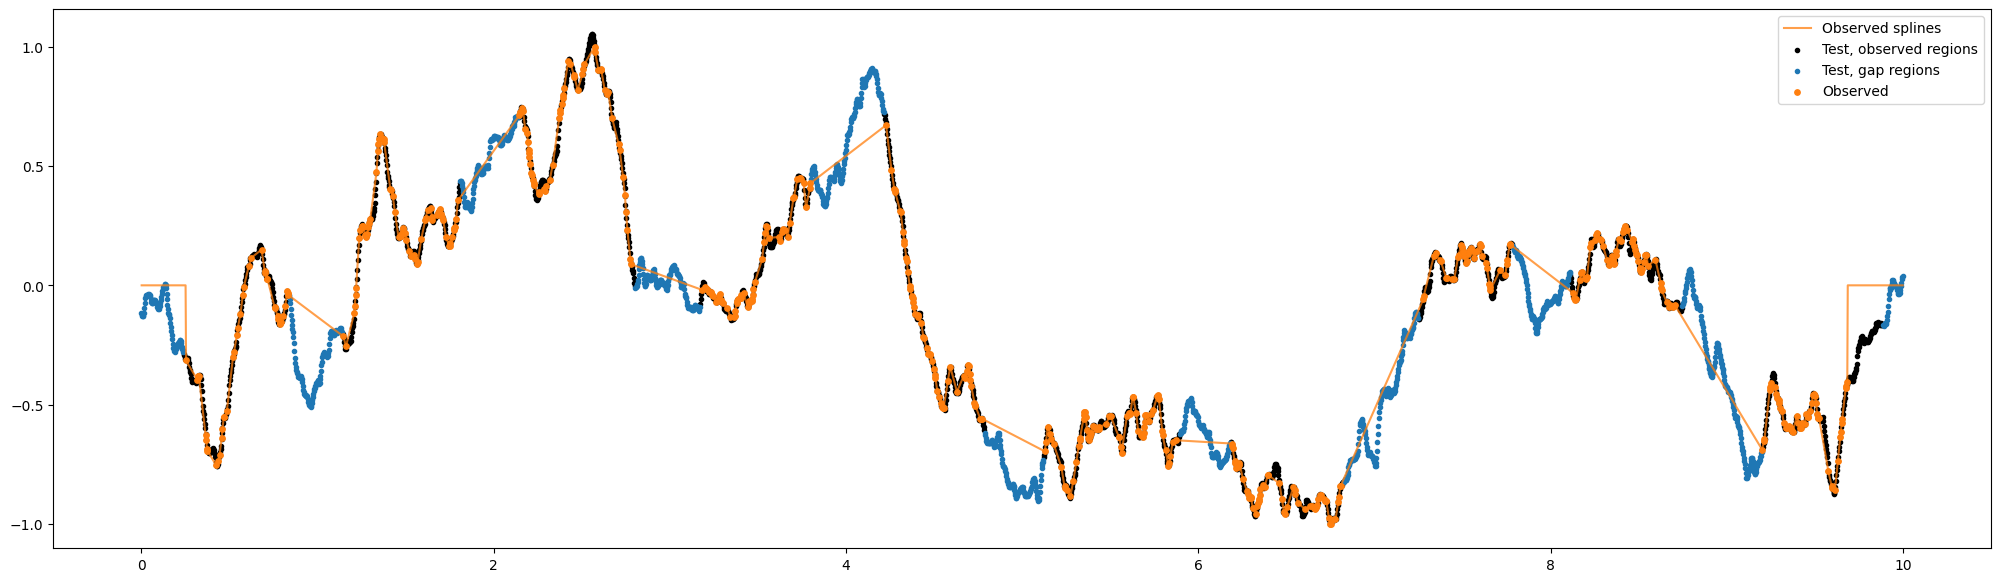

In [50]:
fig,ax = plt.subplots(figsize=(25,7))

plt.scatter(test_time[test_mask],test_magnitude[test_mask],color='k',marker='.',label='Test, observed regions')
plt.scatter(test_time[~test_mask],test_magnitude[~test_mask],color='C0',marker='.',label='Test, gap regions')
plt.scatter(time,magnitude,color='C1',label='Observed',s=15)
plt.plot(dataset.full_query.flatten(),context_splines.flatten(),color='C1',label='Observed splines',alpha=0.75)

plt.legend()

In [51]:
context_splines,time,magnitude,test_time,test_magnitude,test_mask,noise_variance,labels = dataset.get_item(0)

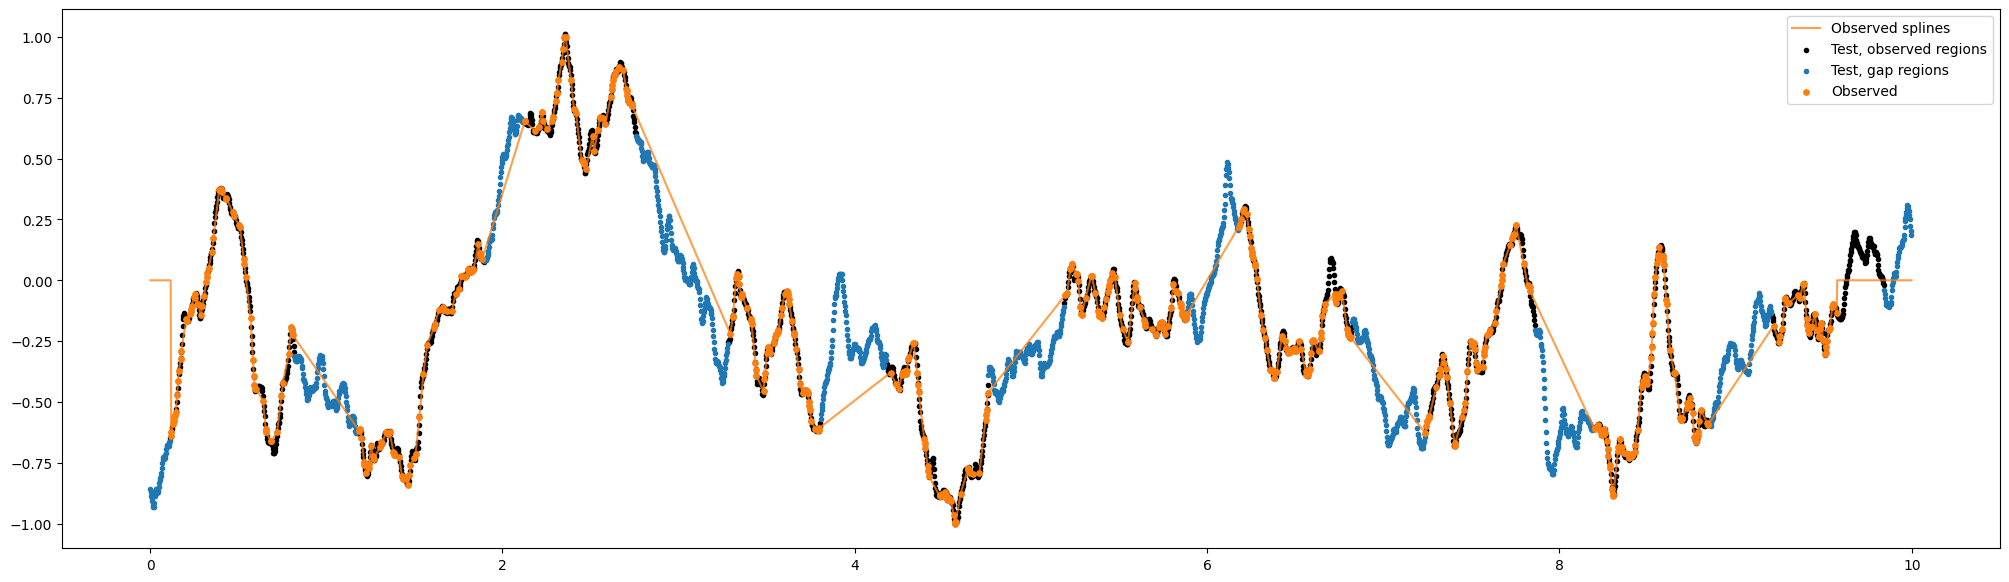

In [52]:
fig,ax = plt.subplots(figsize=(25,7))

plt.scatter(test_time[test_mask],test_magnitude[test_mask],color='k',marker='.',label='Test, observed regions')
plt.scatter(test_time[~test_mask],test_magnitude[~test_mask],color='C0',marker='.',label='Test, gap regions')
plt.scatter(time,magnitude,color='C1',label='Observed',s=15)
plt.plot(dataset.full_query.flatten(),context_splines.flatten(),color='C1',label='Observed splines',alpha=0.75)

plt.legend()

In [11]:
dataset_size = 1000
spline_dataset = np.zeros((dataset_size,*context_splines.shape))
test_magnitude_dataset = np.zeros((dataset_size,*test_magnitude.shape))
test_mask_dataset = np.zeros((dataset_size,*test_mask.shape),dtype=bool)
noise_variance_dataset = np.zeros((dataset_size,1))

obs_times_dataset = []
obs_magnitudes_dataset = []

#tau = 80; rho = 5
tau = 540; rho=30/2/np.pi
simulator = RDRW_simulator(grid_step=1,random_seed=9)
dataset = Train_Test_RDRW(simulator,labels = np.array([[tau,rho]]))

for i in tqdm(range(dataset_size)):
    context_splines,time,magnitude,test_time,test_magnitude,test_mask,noise_variance,labels = dataset.get_item(0)

    spline_dataset[i] = context_splines
    test_magnitude_dataset[i] = test_magnitude
    test_mask_dataset[i] = test_mask
    noise_variance_dataset[i] = noise_variance
    
    obs_times_dataset +=[time]
    obs_magnitudes_dataset+= [magnitude]

100%|██████████| 1000/1000 [00:36<00:00, 27.44it/s]


# Neural network

## Convolutional network

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

def conv_bn_relu(in_dim, out_dim,width_stride=2):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, (3,3), (1,width_stride), 1,bias=False),
        nn.BatchNorm2d(out_dim),
        nn.ReLU())

class VGGBlock(nn.Module):
    def __init__(
        self,
        inplanes: int,
        planes: int,
        strides = (1,1),
    ) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, (3,3), (1,strides[0]), 1,bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, (3,3), (1,strides[1]), 1,bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.pool = nn.MaxPool2d((1,2),(1,2))

    def forward(self, x: Tensor) -> Tensor:

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.pool(out)

        return out

from torch import Tensor

from typing import Any, Callable, List, Optional, Type, Union
#from torchvision.utils import _log_api_usage_once

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=(1,stride),
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=(1,stride), bias=False)

class ResNetBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        strides = [1,1],
    ) -> None:
        super().__init__()

        self.conv1 = conv3x3(inplanes, planes, strides[0])
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes,strides[1])
        self.bn2 = nn.BatchNorm2d(planes)

        if strides != [1,1] or inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(inplanes, planes , np.array(strides).prod()),
                nn.BatchNorm2d(planes),
            )
        else:
          downsample = None


        self.downsample = downsample
        self.strides = strides

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Conv_Net(nn.Module):
  def __init__(
        self,
        block: Type[Union[VGGBlock,ResNetBlock]],
        layers: List[int],
        in_planes = 64,
        strides = [(1,1),(1,1),(1,1),(1,1)]
    ) -> None:
        super().__init__()


        self.in_planes = in_planes
        """
        #self.conv1 = nn.Conv2d(1, self.in_planes, kernel_size=(3,3), stride=(1,2), padding=3, bias=False)
        self.conv1 = conv3x3(1,32,2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(32,in_planes,2)
        self.bn2 = nn.BatchNorm2d(in_planes)
        #self.maxpool = nn.MaxPool2d(kernel_size=(1,3), stride=(1,2), padding=(0,1))

        self.downsample = nn.Sequential(
                conv1x1(1, in_planes , 4),
                nn.BatchNorm2d(in_planes),
            )
        """
        self.in_planes = 1
        self.layer0 = self._make_layer(block, in_planes, layers[0],stride=strides[0])
        self.layer1 = self._make_layer(block, 128, layers[1],stride=strides[1])
        self.layer2 = self._make_layer(block, 256, layers[2], stride=strides[2])
        self.layer3= self._make_layer(block, 512, layers[3], stride=strides[3])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        """
        blocks = 0
        self.out_width = round(365/2) /2 +1


        for layer in layers:
          if layer!=0:
            blocks+=1
            self.out_width = round(self.out_width/2)
          else:
            break

        self.out_filters = int(64 * np.power(2.,blocks))
        """


  def _make_layer(
        self,
        block: Type[Union[VGGBlock,ResNetBlock]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:

        if blocks==0:
            return nn.Identity()

        layers = []
        layers.append(block(self.in_planes, planes, stride))


        self.in_planes = planes

        for _ in range(1, blocks):
            layers.append(
                block(
                    self.in_planes,
                    planes
                )
            )

        return nn.Sequential(*layers)

  def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]

        """
        identity = input

        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        identity = self.downsample(identity)

        x += identity
        x = self.relu(x)
        """


        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        return x


  def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

## Learnable dictionary encoding

In [13]:

import torch.nn.functional as F

class LDE(nn.Module):
    """
    Learnable dictionary encoding layer

    Layer accumulate statistics on more detailed units. It combines
    the dictionary learning and vector encoding steps into a single
    layer for end-to-end learning. It used for speaker embedding creation.

    Parameters
    ----------
    num_clusters : int
        Number of learnable clusters. (defines `C` in papers)
    input_dim : int
        Second dimension of input tensor. The frequency/bands dimension
        of spectrogram squeezed by a encoder model.
    bias : bool
        Parameter of using bias for `weights` creation. default `False`.
        (Is in the original implementation)
    trainable_weights : bool
        Parameter determines the use of additional
        trainable weights for `weights` creation. default `False`.
    pooling : 'mean' or 'mean+std'
        Parameter determines what the returned tensor consists of.
        It change size of last dimension of returned tensor!

    References
    ----------
     - Original implementation:
       https://github.com/jefflai108/pytorch-kaldi-neural-speaker-embeddings/blob/master/scripts/model.py#L334;
     - Introduction of LDE for speaker recognition: https://arxiv.org/abs/1804.05160;
     - LDE for creation speaker embedding for TTS purpose: https://arxiv.org/abs/1910.10838.
    """
    def __init__(self, num_clusters: int, input_dim: int,
                 bias: bool = False, trainable_weights: bool = False,
                 smoothing_factor: float=1., pooling: Union['mean', 'mean+std'] = 'mean+std'):
        super(LDE,self).__init__()


        self.dict = nn.Parameter(torch.randn(num_clusters, input_dim))
        torch.nn.init.normal_(self.dict.data, mean=0.0, std=1.0)
        if trainable_weights:
            self.w = nn.Parameter(torch.ones(num_clusters))
        else:
            self.register_buffer('w', torch.ones(num_clusters) * smoothing_factor)
        self.bias = nn.Parameter(torch.zeros(num_clusters)) if bias else 0
        self.pool = pooling

        # it could be x**2 for 'sqr' instead of 'norm'
        self.distance = lambda x: torch.norm(x, p=2, dim=-1)

        #self.norm = lambda x: F.softmax(-self.distance(x) * (self.w ** 2) + self.bias, dim = -1)

    def norm(self,x,ignore_mask = None):

      weighted_distance = -self.distance(x) * (self.w ** 2) + self.bias

      if ignore_mask is not None:
        weighted_distance.masked_fill_(ignore_mask.view((*weighted_distance.shape[:-1],1)),-1e9)

      return F.softmax(weighted_distance,dim=-1)


    def forward(self, x):
        """
        x: [Batch, Timesteps, 1, Freq]
        mask: [Batch,Freq]

        """

        x = x.unsqueeze(-2)                                                     # [Batch, Timesteps, 1, Freq]
        residual_tensor = (x - self.dict)                                # [Batch, Timesteps, num_clusters, Freq]

        weights = self.norm(residual_tensor)                        # [Batch, Timesteps, num_clusters]
        weights = weights.unsqueeze(-1)                                         # [Batch, Timesteps, num_clusters, 1]
        weights = weights / (torch.sum(weights, dim=1, keepdim=True) + 1e-9)

        means = torch.sum(weights * residual_tensor, dim=1)    # [Batch, num_clusters, Freq]
        if self.pool == 'mean+std':
            stds = torch.sqrt(torch.sum(weights * residual_tensor ** 2, dim=1) + 1e-9)
            means_and_stds = torch.cat([means, stds], dim=-1)
            return means_and_stds.view(x.size(0), -1)                           # [Batch, 2 * num_clusters * Freq]

        return means
        #return means.view(x.size(0), -1)                                        # [Batch, num_clusters * Freq]

## Whole network

In [14]:
import einops

class Neural_Regression_with_LDE(nn.Module):

    def __init__(self,conv_net,num_clusters=8,output_dim=2,lde_filters = 64,dropout_rate=0.):
        super().__init__()

        self.conv_net = conv_net

        x = torch.zeros((1,1,5,365))
        x = conv_net(x)

        conv_out_filters,conv_out_height,conv_out_width = x.shape[-3:]
        x = None

        self.conv_out_height = conv_out_height
        self.conv_out_filters = conv_out_filters
        self.conv_out_width = conv_out_width
        
        self.dropout = nn.Dropout(dropout_rate)
        self.project_patches = torch.nn.Linear(conv_out_filters,lde_filters)
        
        self.lde = LDE(num_clusters,lde_filters,bias= True,trainable_weights=True,pooling='mean')

        self.batchnorm = nn.BatchNorm1d(lde_filters)

        self.linear = nn.Linear(num_clusters*lde_filters,output_dim)



    def forward(self,context_splines):

        encoding = self.conv_net(context_splines)
        batched_encodings = einops.rearrange(encoding, 'b c (h p1) (w p2)->b (h w p1 p2) c', p1=self.conv_out_height, p2=self.conv_out_width)

        patches = self.dropout(batched_encodings)
        patches = self.project_patches(patches)
        

        y = self.lde(patches)

        patches = self.dropout(y)
        #y = self.batchnorm(y.transpose(-2,-1))
        y = self.linear(y.view(context_splines.shape[0],-1))

        return y

## Initialize

In [41]:
import torchsummary

conv_net = Conv_Net(block=ResNetBlock,layers=[1,1,1,0],strides=[(1,2),(2,1),(2,2),(0,0)])
neural_regression = Neural_Regression_with_LDE(conv_net,output_dim=2,num_clusters=64,lde_filters=64,dropout_rate=0.1).to(device)


_ = torch.nn.init.xavier_normal_(neural_regression.linear.weight)
torchsummary.summary(neural_regression,(1,10,365))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 10, 365]             576
       BatchNorm2d-2          [-1, 64, 10, 365]             128
              ReLU-3          [-1, 64, 10, 365]               0
            Conv2d-4          [-1, 64, 10, 183]          36,864
       BatchNorm2d-5          [-1, 64, 10, 183]             128
            Conv2d-6          [-1, 64, 10, 183]              64
       BatchNorm2d-7          [-1, 64, 10, 183]             128
              ReLU-8          [-1, 64, 10, 183]               0
       ResNetBlock-9          [-1, 64, 10, 183]               0
           Conv2d-10          [-1, 128, 10, 92]          73,728
      BatchNorm2d-11          [-1, 128, 10, 92]             256
             ReLU-12          [-1, 128, 10, 92]               0
           Conv2d-13          [-1, 128, 10, 92]         147,456
      BatchNorm2d-14          [-1, 128,

In [16]:
from google.colab import drive
# Change to mount '/content/drive/My Drive/Fermilab/'
drive.mount('/content/drive')
Folder='/content/drive/MyDrive/Fermilab/'

#!pip install scipy==1.7.1 --quiet
#!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.11.0+cu113.html --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
log_dir= Folder+'Neural_Networks/Neural_regression/10_years_Fourier_sampling_grid_step_4_300k_samples/ResNet_layers_1_1_1_0_strides_12_21_22_00_LDE_64_64_dropout_01/'


In [43]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%4)
neural_regression.load_state_dict(model_dict['regressor'])
label_mean = torch.tensor(model_dict['label_mean']).to(device)
label_std = torch.tensor(model_dict['label_std']).to(device)

In [44]:
def transform_labels_to_targets(labels,mean=label_mean,std=label_std):

    return (labels - mean)/std

def transform_targets_to_labels(targets,mean=label_mean,std=label_std):

    return targets * std + mean

## Prediction

In [45]:
net = neural_regression.eval()

In [46]:
NN_predictions = np.zeros((dataset_size,2))

for i in tqdm(range(dataset_size//100)):
    x = spline_dataset[i*100:(i+1)*100]
    x = torch.from_numpy(np.stack(x)).type(torch.float32).to(device).unsqueeze(1)

    pred = net(x)
    pred = transform_targets_to_labels(pred).cpu().detach()

    NN_predictions[i*100:(i+1)*100] = pred

100%|██████████| 10/10 [00:00<00:00, 31.42it/s]


In [47]:
x = None
pred = None
neural_regression = None
net = None


import gc
gc.collect()
torch.cuda.empty_cache()

In [48]:
np.sqrt(np.mean((NN_predictions[:,1] - rho)**2))

0.8344909924883491

In [49]:
np.sqrt(np.mean((NN_predictions[:,0] - np.log10(tau))**2))

0.20545943086842006

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


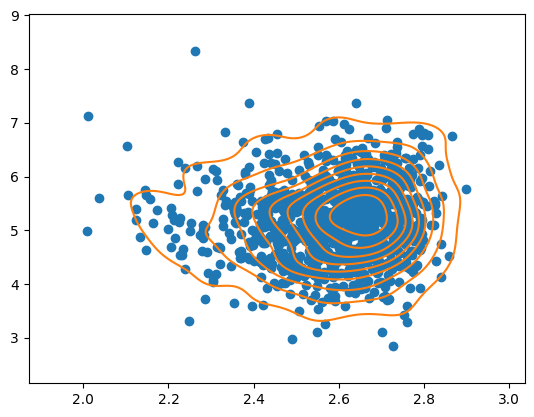

In [50]:
plt.scatter(NN_predictions[:,0],NN_predictions[:,1])
sns.kdeplot(NN_predictions[:,0],NN_predictions[:,1],color='C1')

# Max likelihood

In [51]:
def RDRW_kernel(time_difference, Variance, Correlation_time, Reverberation_time):
    """
    Autocorrelation function of Reverberating Damped Random Walk process. This is a difference of two Mater[nu=0.5] kernels.
    Formally it is subtraction of two laplacian kernels

    .. math::
        R_{FF}(\\Delta t) = \\sigma^2  \\frac{1}{t_{corr}- t_{rev}}
            \\left(t_{corr} e^{-\\frac{|\\Delta t|}{t_{corr}}} - t_{rev} e^{-\\frac{|\\Delta t|}{t_{rev}}}\\right),

    Parameters
    ----------
    time_difference: float [days]
        Difference in time between two points, for which correlation is estimated
    Variance: float
        Variance of a sampled point
    Correlation_time: float [days]
        Measure of global correlation between separated points. Defines global evolution.
    Reverberation_time: float [days]
        Measure of local correlation between separated points. Defines locall evolution.
        It is assumed that Reverberation_time<Correlation_time

    Returns
    -------
    R_{FF}(t_i - t_j) : float
        Correlation of radiation on time stamps t_i and t_j (stationary,isotropic)
    """


    Normalisation = 1. / (Correlation_time  - Reverberation_time)
    Time_dependence = Correlation_time * jnp.exp(-jnp.abs(time_difference) / (Correlation_time + eps)) - \
                      Reverberation_time * jnp.exp(-jnp.abs(time_difference) / (Reverberation_time + eps))


    return Variance*Normalisation*Time_dependence

@partial(jax.jit,backend='gpu')
def Cholesky_of_Covariance_matrix(time_array: jnp.ndarray, Normalised_errors: jnp.ndarray, Correlation_time: float,
                                  Reverberation_time: float):
    """
    Cholesky decomposition of Covariance matrix with unit variance

    Parameters
    ----------
    time_array: array (N,) [days]
        time stamps, on which the process should be sampled
    Normalised_errors: array (N,)
        Observation errors normalised by the Gaussian process' variance
    Correlation_time: float [days]
        Measure of global correlation between separated points. Defines global evolution.
    Reverberation_time: float [days]
        Measure of local correlation between separated points. Defines local evolution.
        It is assumed that Reverberation_time<Correlation_time

    Returns
    -------
        L: ndarray (N,N)
            Low triangular decomposition of the Covariance matrix
    """

    N = len(time_array)

    # Distance between time points for autocorrelation function
    x, y = jnp.meshgrid(time_array, time_array)
    time_difference = x - y

    get_Covariance = lambda time_difference: RDRW_kernel(time_difference, 1.,
                                                             Correlation_time, Reverberation_time)

    # Covariance kernel (unit variance in a time point)
    Covariance_matrix = get_Covariance(time_difference) + jnp.diag(Normalised_errors)
    # Now use Cholesky decomposition, but might change to sparce matrices jax.scipy.sparse.linalg
    Low_triangular_Covariance = jax.scipy.linalg.cholesky(Covariance_matrix, lower=True, overwrite_a=True)

    return Low_triangular_Covariance

@partial(jax.jit, static_argnums=(7, 8),backend='gpu')
def NegLogLikelihood(time_array: jnp.ndarray, values_array: jnp.ndarray, errors_array: jnp.ndarray,
                     Mean: float, Variance: float, Correlation_time: float,
                     Reverberation_time:float, Curve_type='RDRW', Normalised=True):
    """
    Estimates negative log-likelihood of hypothesis that a given time series (t,v) with errors e
    is a gaussian process with the parameters Mean,Variance,Correlation_time,Reverberation_time
    Parameters
    ----------
    time_array: array (N,) [days]
        time stamps, on which the process should be sampled
    values_array: array (N,) [days]
        values observed in the time points
    errors_array: array (N,) [days]
        uncertainties on those values expressed as gaussian standard deviation
    Mean: float
        Mean of the Gaussian process
    Variance: float
        Variance of the Gaussian process
    Correlation_time: float [days]
        Measure of global correlation between separated points. Defines global evolution.
    Reverberation_time: float [days]
        Measure of local correlation between separated points. Defines local evolution.
        It is assumed that Reverberation_time<Correlation_time
    Noise_std: float
        Std of noise atributed to the data
    Curve_type: 'RDRW' or 'DRW'
        Assumes either Reverberating Damped Random Walk (RDRW) kernel or DRW kernel (Matern[0.5])
    Normalised: bool
        True to include factor normalising total probability from the PDF to 1. False to consider 1/2*chi^2

    Returns
    -------
        -lnp(mu,sigma^2,t_corr,t_rev|t,x,e): float
    """

    N=len(time_array)


    # Use Cholesky decomposition to get lower triangle matrix describing covariance
    Low_triangular_Covariance = Cholesky_of_Covariance_matrix(time_array, (errors_array ** 2) / Variance,
                                                                   Correlation_time, Reverberation_time)

    # Mean estimation mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)
    one = jnp.ones_like(values_array)

    # Euclidian Error estimation (self.y-mu*one).T @ inv_K @ (self.y-mu*one)
    Squared_Error = (values_array - Mean * one).T @ (jax.scipy.linalg.cho_solve((Low_triangular_Covariance, True), values_array - Mean * one))
    Chi_squared = Squared_Error / Variance / 2

    if not Normalised:
        return Chi_squared
    else:
        # log(det(K))
        LnDetCov = 2 * jnp.sum(jnp.log(jnp.diag(Low_triangular_Covariance)))
        # Normalisation of multivariate gaussian distribution
        Normalisation = 0.5 * N * (np.log(2*np.pi) + jnp.log(Variance)) + 0.5 * LnDetCov
        return Normalisation + Chi_squared

def Conditional_distribution(desired_times,time_array, values_array, errors_array, Mean, Variance,
            Correlation_time, Reverberation_time, Curve_type = 'RDRW',return_cov_matrix = False):

    one = jnp.ones_like(values_array)

    get_Covariance = lambda time_difference: RDRW_kernel(time_difference, 1.,
                                                             Correlation_time, Reverberation_time)

    time_difference = desired_times[None,:] - time_array[:,None]

    Covariances = get_Covariance(time_difference)

    Low_triangular_Covariance =  Cholesky_of_Covariance_matrix(time_array, (errors_array ** 2) / Variance,
                                                                   Correlation_time, Reverberation_time)

    # Mean prediction
    alpha = (jax.scipy.linalg.cho_solve((Low_triangular_Covariance, True), values_array - Mean * one))

    predicted_mean = Mean + Covariances.T @ alpha
    # f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)

    V = jax.scipy.linalg.solve_triangular(Low_triangular_Covariance,Covariances,lower=True,check_finite=False)

    err = (errors_array ** 2).mean()

    if return_cov_matrix:
        desired_time_difference = desired_times[None,:] - desired_times[:,None]
        predicted_corr_matrix = get_Covariance(desired_time_difference) - V.T @ V
        predicted_cov_matrix = Variance * predicted_corr_matrix  + np.eye(len(desired_times))*err
        return np.array(predicted_mean),np.array(predicted_cov_matrix)
    else:
        predicted_covariance =  get_Covariance(0.) - jnp.einsum("ij,ji->i", V.T, V)
        predicted_variance = Variance * predicted_covariance + err
        return np.array(predicted_mean),np.array(predicted_variance)

In [211]:
eps= 1e-8
class Optimizer():

    def __init__(self,time_array,value_array,errors_array,Correlation_time = None,Reverberation_time = None,
                 normalisation: Union['day','year'] = 'day',report_learning = False,random_seed=7,Reverberation_time_guess = None):

        self.normalisation = normalisation

        if normalisation=='day':
            self.times = time_array / 365
        else:
            self.times = time_array

        self.values = value_array
        self.errors = errors_array

        self.Mean = None
        self.Variance = None

        rng = np.random.default_rng(random_seed)

        if (Correlation_time is None) and (Reverberation_time is None):
            self.optimized_task = 'All free'
            # default
            log_tau = scipy.stats.uniform(log_tau_bounds[0],log_tau_bounds[1]-log_tau_bounds[0]).rvs(size=1,random_state=rng)
            if Reverberation_time_guess is None:
              rho = scipy.stats.uniform(rho_bounds[0],rho_bounds[1]-rho_bounds[0]).rvs(size=1,random_state=rng)
            else:
              rho = Reverberation_time_guess
            Correlation_time = np.power(10,log_tau)
            Reverberation_time = rho
            
        elif (Correlation_time is not None) and (Reverberation_time is None):
            self.optimized_task = 'Fixed tau'
            if Reverberation_time_guess is None:
              rho = scipy.stats.uniform(rho_bounds[0],rho_bounds[1]-rho_bounds[0]).rvs(size=1,random_state=rng)
            else:
              rho = Reverberation_time_guess
        
        elif (Correlation_time is None) and (Reverberation_time is not None):

            self.optimized_task = 'Fixed rho'
            
            log_tau = scipy.stats.uniform(log_tau_bounds[0],log_tau_bounds[1]-log_tau_bounds[0]).rvs(size=1,random_state=rng)
            Correlation_time = np.power(10,log_tau)
        else:
            self.optimized_task = 'Fixed kernel'



        self.Correlation_time = Correlation_time /365
        self.Reverberation_time = Reverberation_time /365


        self.report_learning = report_learning


    def _args_to_labels(self,Arguments):
        Mean = Arguments[0]

        if self.optimized_task == 'All free':
            Correlation_time = np.power(10, Arguments[2])
            Reverberation_time = np.power(10, Arguments[3])
        elif self.optimized_task == 'Fixed tau':
            Correlation_time = self.Correlation_time
            Reverberation_time = np.power(10, Arguments[2])
        elif self.optimized_task == 'Fixed rho':
            Correlation_time = np.power(10, Arguments[2])
            Reverberation_time = self.Reverberation_time
        else:
            Correlation_time = self.Correlation_time
            Reverberation_time = self.Reverberation_time

        Variance = np.power(10, Arguments[1]) * (Correlation_time + Reverberation_time)

        Labels = [Mean, Variance, Correlation_time, Reverberation_time]


        return np.array(Labels)

    @partial(jax.jit, static_argnums=(0,),backend='gpu')
    def Full_Loss_RDRW(self, Arguments):

        Mean, Descaled_logVariance = Arguments[:2]

        log_Correlation_time, log_Reverberation_time = Arguments[2:4]

        Correlation_time = jnp.power(10, log_Correlation_time)
        Reverberation_time = jnp.power(10, log_Reverberation_time)
        Variance = jnp.power(10, Descaled_logVariance) * (Correlation_time + Reverberation_time)

        NLL = NegLogLikelihood(self.times, self.values, self.errors, Mean, Variance,
                                                 Correlation_time, Reverberation_time, Curve_type='RDRW',
                                                 Normalised=True)

        return NLL

    @partial(jax.jit, static_argnums=(0,),backend='gpu')
    def Fixed_kernel_Loss_RDRW(self, Arguments):

        Mean, Descaled_logVariance = Arguments[:2]

        Correlation_time = self.Correlation_time
        Reverberation_time = self.Reverberation_time
        Variance = jnp.power(10, Descaled_logVariance) * (Correlation_time + Reverberation_time)

        NLL = NegLogLikelihood(self.times, self.values, self.errors, Mean, Variance,
                                                 Correlation_time, Reverberation_time, Curve_type='RDRW',
                                                 Normalised=True)

        return NLL

    @partial(jax.jit, static_argnums=(0,),backend='gpu')
    def Fixed_Tau_Loss_RDRW(self, Arguments):

        Mean, Descaled_logVariance,log_Reverberation_time = Arguments[:3]

        Correlation_time = self.Correlation_time
        Reverberation_time = jnp.power(10, log_Reverberation_time)
        Variance = jnp.power(10, Descaled_logVariance) * (Correlation_time + Reverberation_time)

        NLL = NegLogLikelihood(self.times, self.values, self.errors, Mean, Variance,
                                                 Correlation_time, Reverberation_time, Curve_type='RDRW',
                                                 Normalised=True)

        return NLL

    @partial(jax.jit, static_argnums=(0,),backend='gpu')
    def Fixed_Rho_Loss_RDRW(self, Arguments):

        Mean, Descaled_logVariance,log_Correlation_time = Arguments[:3]

        
        Correlation_time = jnp.power(10, log_Correlation_time)

        Reverberation_time = self.Reverberation_time
        Variance = jnp.power(10, Descaled_logVariance) * (Correlation_time + Reverberation_time)

        NLL = NegLogLikelihood(self.times, self.values, self.errors, Mean, Variance,
                                                 Correlation_time, Reverberation_time, Curve_type='RDRW',
                                                 Normalised=True)

        return NLL

    def compile_loss(self):

        if self.optimized_task == 'All free':
            return self.Full_Loss_RDRW
        elif self.optimized_task == 'Fixed tau':
            return self.Fixed_Tau_Loss_RDRW
        elif self.optimized_task == 'Fixed rho':
            return self.Fixed_Rho_Loss_RDRW
        else:
            return self.Fixed_kernel_Loss_RDRW

    def _prepare_for_optimization(self):

        Mean = self.values.mean()


        Correlation_time = self.Correlation_time
        Reverberation_time = self.Reverberation_time

        Descaled_Variance = self.values.var() / (Correlation_time + Reverberation_time)

        initial_RDRW_guess = np.array([Mean, jnp.log10(Descaled_Variance),
                                       jnp.log10(Correlation_time), jnp.log10(Reverberation_time)])

        Mean_bounds = [self.values.min(), self.values.max()]
        # log_Corr_time_bounds = [np.log10(np.diff(time_array).min()),np.log10(time_array.max())] # from https://iopscience.iop.org/article/10.1088/0004-637X/698/1/895/pdf
        log_Corr_time_bounds = [1. - np.log10(365) + eps, np.inf]
        log_Rev_time_bounds = [-np.inf, 1. - np.log10(365) - eps]

        lower_bound = np.array((Mean_bounds[0], -np.inf, log_Corr_time_bounds[0], log_Rev_time_bounds[0]))
        upper_bound = np.array((Mean_bounds[1], np.inf, log_Corr_time_bounds[1], log_Rev_time_bounds[1]))

        #bounds_RDRW = scipy.optimize.Bounds(lb=lower_bound,
        #                                    ub=upper_bound, keep_feasible=True)

        return initial_RDRW_guess,lower_bound,upper_bound

    def optimize(self,initial_guess = None, lower_bound = None ,upper_bound = None, **kwargs):

        suggestions = self._prepare_for_optimization()

        if initial_guess is None:
            initial_guess = suggestions[0]

        if lower_bound is None:
            lower_bound = suggestions[1]

        if upper_bound is None:
            upper_bound = suggestions[2]


        if self.optimized_task == 'All free':
            bounds = scipy.optimize.Bounds(lb=lower_bound,
                                            ub=upper_bound, keep_feasible=True)
        elif self.optimized_task == 'Fixed tau':
            initial_guess = initial_guess[[0,1,3]]
            bounds = scipy.optimize.Bounds(lb=lower_bound[[0,1,3]],
                                            ub=upper_bound[[0,1,3]], keep_feasible=True)
        elif self.optimized_task == 'Fixed rho':
            initial_guess = initial_guess[[0,1,2]]
            bounds = scipy.optimize.Bounds(lb=lower_bound[[0,1,2]],
                                            ub=upper_bound[[0,1,2]], keep_feasible=True)
        else:
            initial_guess = initial_guess[:-2]
            bounds = scipy.optimize.Bounds(lb=lower_bound[:-2],
                                            ub=upper_bound[:-2], keep_feasible=True)


        Loss_RDRW = self.compile_loss()
        grad = jax.grad(Loss_RDRW)
        hess = jax.jacfwd(jax.jacrev(Loss_RDRW))

        result, learning_curve = self._optimize(Loss_RDRW,grad,hess,initial_guess,bounds,**kwargs)

        labels = self._args_to_labels(result)
        labels[2:] = labels[2:] * 365

        return labels,learning_curve



    def _optimize(self,Loss, Gradient, Hessian, guess, bounds, method='TNC', options=None, use_hessian=False):

        if options is None:
            # options = {'disp':True,'maxiter':500}
            options = {}

        learning_curve = []

        global step
        step = 1

        def callbackF(Xi, *args):
            global step
            if self.report_learning:
                print(step , np.array(Xi))
            loss = Loss(Xi)

            learning_curve.append([*Xi, loss.item()])

            step += 1


        hess = lambda x: np.array(Hessian(x))
        if not use_hessian:
            hess = None

        def loss(x):
            l = Loss(x)
            if self.report_learning:
                print(x,l)
            return l

        grad = lambda x: np.array(Gradient(x))

        res = scipy.optimize.minimize(loss, guess, method=method, jac=grad, hess=hess,
                                      bounds=bounds, options=options)

        return res.x, learning_curve

# Performance tests

In [215]:
i = 0
time = obs_times_dataset[i]
magnitude = obs_magnitudes_dataset[i]
noise_variance = noise_variance_dataset[i]

test_time = np.arange(10*365)/365

test_magnitude = test_magnitude_dataset[i]
test_mask = test_mask_dataset[i]

In [216]:
optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance),
                                  normalisation='year',Reverberation_time=0.,report_learning=False)
result_DRW,_ = optimizer.optimize()

In [217]:
result_DRW

array([-2.14293442e-01,  1.87887978e-01,  9.95129174e+02,  0.00000000e+00])

In [71]:
optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance),
                                  normalisation='year',report_learning=False)
result_MLE,_ = optimizer.optimize()

optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance),
                                  normalisation='year',Correlation_time=np.power(10,NN_predictions[i,0]),Reverberation_time=NN_predictions[i,1],report_learning=False)
result_NN,_ = optimizer.optimize()

In [72]:
result_NN

array([ -0.22190527,   0.22398188, 173.23362853,   6.15937662])

In [73]:
result_MLE

array([ -0.21854098,   0.15952962, 153.77198595,   5.26996485])

In [77]:
mean_MLE, var_MLE = Conditional_distribution(test_time*365, time*365, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance), *result_MLE,return_cov_matrix=True)
mean_NN, var_NN = Conditional_distribution(test_time*365, time*365, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance), *result_NN,return_cov_matrix=True)

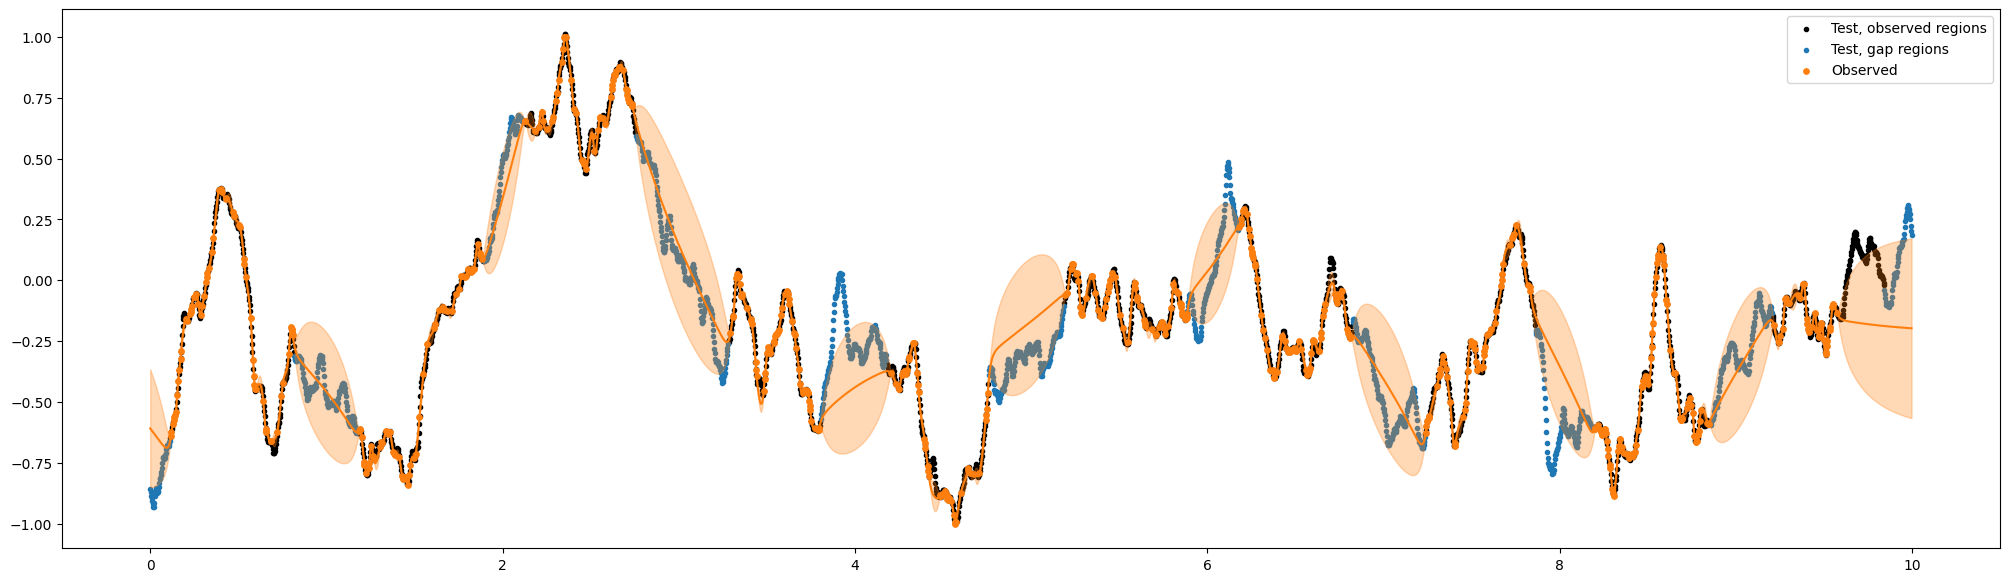

In [78]:
fig,ax = plt.subplots(figsize=(25,7))

plt.scatter(test_time[test_mask],test_magnitude[test_mask],color='k',marker='.',label='Test, observed regions')
plt.scatter(test_time[~test_mask],test_magnitude[~test_mask],color='C0',marker='.',label='Test, gap regions')
plt.scatter(time,magnitude,color='C1',label='Observed',s=15)

plt.plot(test_time,mean_MLE,color='C1')
plt.fill_between(test_time,mean_MLE+np.sqrt(np.diag(var_MLE)),mean_MLE-np.sqrt(np.diag(var_MLE)),alpha=0.3,color='C1')

plt.legend()

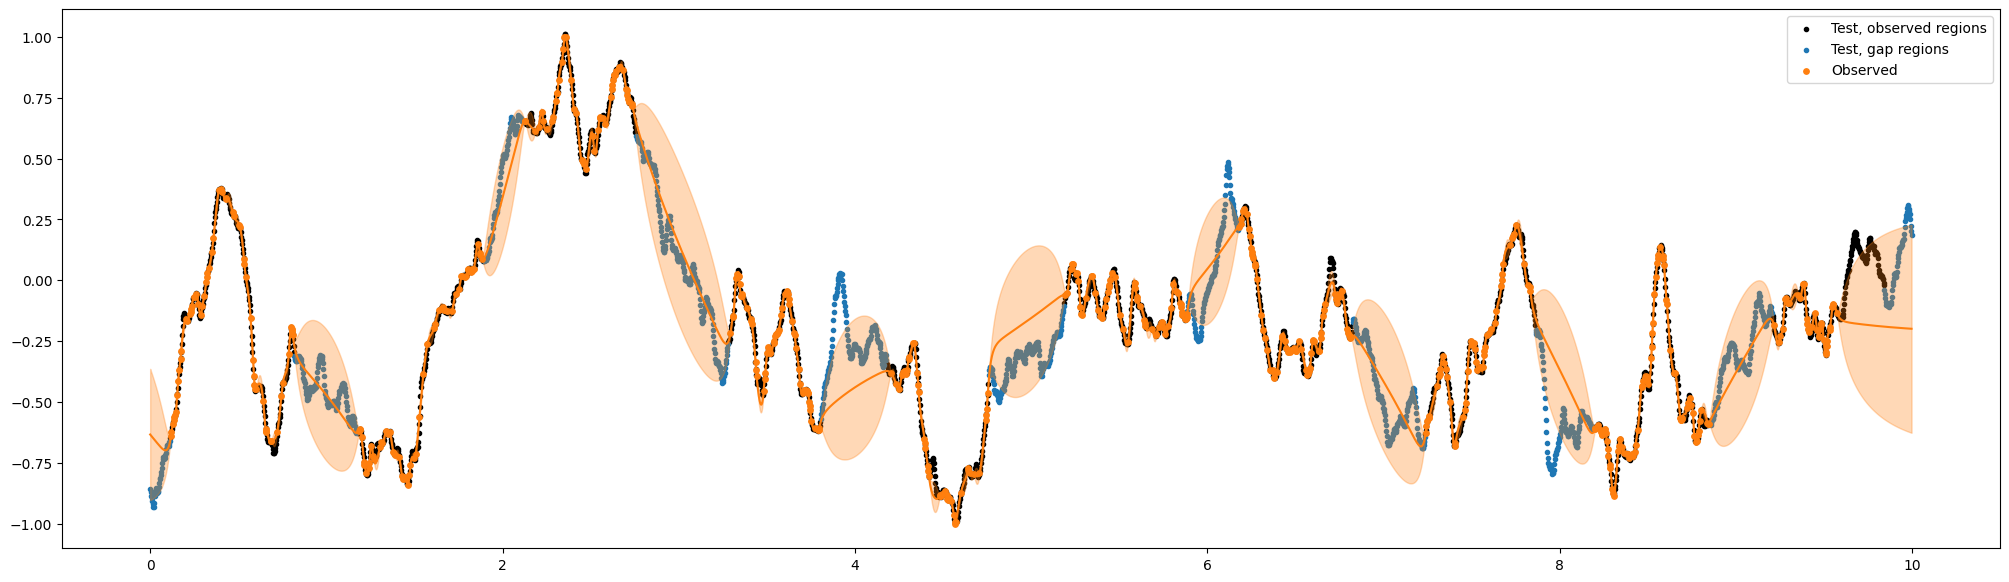

In [79]:
fig,ax = plt.subplots(figsize=(25,7))

plt.scatter(test_time[test_mask],test_magnitude[test_mask],color='k',marker='.',label='Test, observed regions')
plt.scatter(test_time[~test_mask],test_magnitude[~test_mask],color='C0',marker='.',label='Test, gap regions')
plt.scatter(time,magnitude,color='C1',label='Observed',s=15)

plt.plot(test_time,mean_NN,color='C1')
plt.fill_between(test_time,mean_NN+np.sqrt(np.diag(var_NN)),mean_NN-np.sqrt(np.diag(var_NN)),alpha=0.3,color='C1')

plt.legend()

In [55]:
def compute_metrics(test_magnitude,test_mask,predicted_mean,predicted_var):

    test_data = test_magnitude[test_mask]

    pred_data = predicted_mean[test_mask]

    pred_uncertainty = np.sqrt(np.diag(predicted_var))[test_mask]

    chi2 = np.mean(((test_data - pred_data)/pred_uncertainty)**2)
    mae = np.mean(np.abs(test_data - pred_data))
    rmse = np.sqrt(np.mean((test_data - pred_data)**2))
    mad = np.median(np.abs(test_data - pred_data))

    return chi2,mae,rmse,mad

In [61]:
import pandas as pd
df_MLE = pd.DataFrame(np.zeros((dataset_size,14)),columns = ['Tau','Rho','Chi2_full','MAE_full','MAD_full','RMSE_full',
                                                            'Chi2_obs','MAE_obs','MAD_obs','RMSE_obs',
                                                            'Chi2_gap','MAE_gap','MAD_gap','RMSE_gap'])

for i in tqdm(range(dataset_size)):

  time = obs_times_dataset[i]
  magnitude = obs_magnitudes_dataset[i]
  noise_variance = noise_variance_dataset[i]

  test_time = np.arange(10*365)/365

  test_magnitude = test_magnitude_dataset[i]
  test_mask = test_mask_dataset[i]

  optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance),
                                  normalisation='year',report_learning=False)
  result_MLE,_ = optimizer.optimize()

  mean_MLE, var_MLE = Conditional_distribution(test_time*365, time*365, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance), *result_MLE,return_cov_matrix=True)

  full_metrics = compute_metrics(test_magnitude,np.ones_like(test_mask),mean_MLE,var_MLE)
  obs_metrics = compute_metrics(test_magnitude,test_mask,mean_MLE,var_MLE)
  gap_metrics = compute_metrics(test_magnitude,~test_mask,mean_MLE,var_MLE)

  metrics = np.array([*result_MLE[-2:],*full_metrics,*obs_metrics,*gap_metrics]) 

  df_MLE.iloc[i] = metrics


 77%|███████▋  | 771/1000 [51:24<15:02,  3.94s/it]

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


 77%|███████▋  | 771/1000 [51:28<15:17,  4.01s/it]

Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: ignored

In [78]:
for i in tqdm(range(771,dataset_size)):

  time = obs_times_dataset[i]
  magnitude = obs_magnitudes_dataset[i]
  noise_variance = noise_variance_dataset[i]

  test_time = np.arange(10*365)/365

  test_magnitude = test_magnitude_dataset[i]
  test_mask = test_mask_dataset[i]

  optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance),
                                  normalisation='year',report_learning=False)
  try:
    result_MLE,_ = optimizer.optimize()

    mean_MLE, var_MLE = Conditional_distribution(test_time*365, time*365, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance), *result_MLE,return_cov_matrix=True)

    full_metrics = compute_metrics(test_magnitude,np.ones_like(test_mask),mean_MLE,var_MLE)
    obs_metrics = compute_metrics(test_magnitude,test_mask,mean_MLE,var_MLE)
    gap_metrics = compute_metrics(test_magnitude,~test_mask,mean_MLE,var_MLE)

    metrics = np.array([*result_MLE[-2:],*full_metrics,*obs_metrics,*gap_metrics]) 
  except:
    metrics = np.ones(14)*np.nan

  df_MLE.iloc[i] = metrics

  0%|          | 1/229 [00:01<06:25,  1.69s/it]

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


100%|██████████| 229/229 [14:14<00:00,  3.73s/it]


In [79]:
#df_MLE.to_csv(log_dir+'/Performance_check/MLE_metrics.csv')

In [80]:
from copy import deepcopy
q = deepcopy(df_MLE[['Tau','Rho']].iloc[:771]).to_numpy()
q = q[q[:,0]<1000]

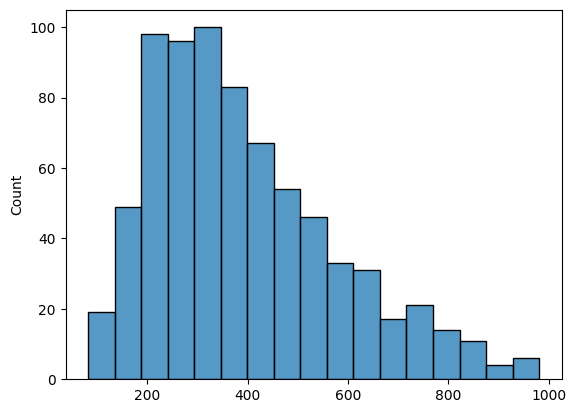

In [81]:
sns.histplot(q[:,0])

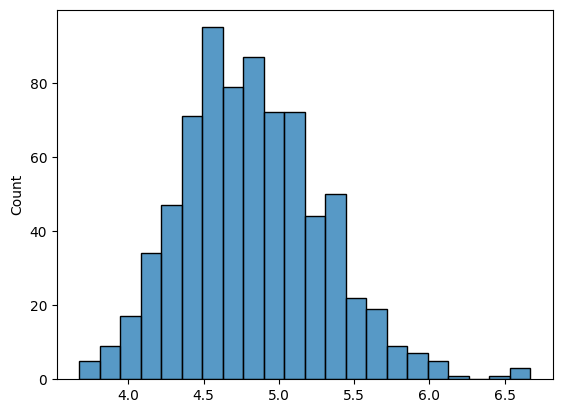

In [82]:
sns.histplot(q[:,1])

In [83]:
np.sqrt(np.mean((np.log10(q[:,0])-np.log10(tau))**2))

0.27693562348094786

In [84]:
np.sqrt(np.mean((q[:,1]-rho)**2))

0.47172244986830764

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


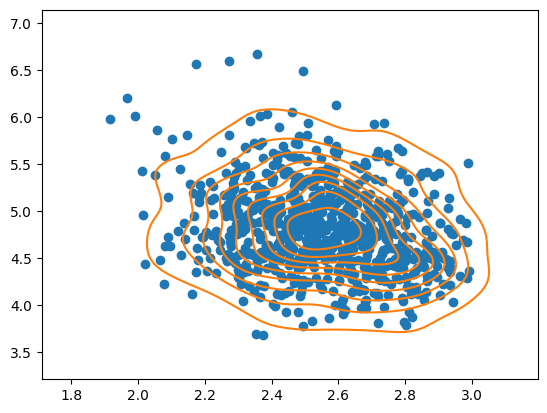

In [86]:
plt.scatter(np.log10(q[:,0]),q[:,1])
sns.kdeplot(np.log10(q[:,0]),q[:,1],color='C1')

In [87]:
import pandas as pd
df_NN = pd.DataFrame(np.zeros((dataset_size,14)),columns = ['Tau','Rho','Chi2_full','MAE_full','MAD_full','RMSE_full',
                                                            'Chi2_obs','MAE_obs','MAD_obs','RMSE_obs',
                                                            'Chi2_gap','MAE_gap','MAD_gap','RMSE_gap'])

for i in tqdm(range(dataset_size)):

  time = obs_times_dataset[i]
  magnitude = obs_magnitudes_dataset[i]
  noise_variance = noise_variance_dataset[i]

  test_time = np.arange(10*365)/365

  test_magnitude = test_magnitude_dataset[i]
  test_mask = test_mask_dataset[i]

  optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance),
                                  normalisation='year',Correlation_time=np.power(10,NN_predictions[i,0]),Reverberation_time=NN_predictions[i,1],report_learning=False)
  try:
    result_NN,_ = optimizer.optimize()

    mean_NN, var_NN = Conditional_distribution(test_time*365, time*365, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance), *result_NN,return_cov_matrix=True)

    full_metrics = compute_metrics(test_magnitude,np.ones_like(test_mask),mean_NN,var_NN)
    obs_metrics = compute_metrics(test_magnitude,test_mask,mean_NN,var_NN)
    gap_metrics = compute_metrics(test_magnitude,~test_mask,mean_NN,var_NN)
  except:
    metrics = np.ones(14)*np.nan

  metrics = np.array([*result_NN[-2:],*full_metrics,*obs_metrics,*gap_metrics]) 

  df_NN.iloc[i] = metrics


100%|██████████| 1000/1000 [38:22<00:00,  2.30s/it]


In [88]:
#df_NN.to_csv(log_dir+'/Performance_check/NN_metrics.csv')

In [127]:
import pandas as pd
df_NN_MLE = pd.DataFrame(np.zeros((dataset_size,14)),columns = ['Tau','Rho','Chi2_full','MAE_full','MAD_full','RMSE_full',
                                                            'Chi2_obs','MAE_obs','MAD_obs','RMSE_obs',
                                                            'Chi2_gap','MAE_gap','MAD_gap','RMSE_gap'])

for i in tqdm(range(dataset_size)):

  time = obs_times_dataset[i]
  magnitude = obs_magnitudes_dataset[i]
  noise_variance = noise_variance_dataset[i]

  test_time = np.arange(10*365)/365

  test_magnitude = test_magnitude_dataset[i]
  test_mask = test_mask_dataset[i]

  optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance),
                                  normalisation='year',
                        Correlation_time=np.power(10,NN_predictions[i,0]),Reverberation_time=None,report_learning=False,Reverberation_time_guess=NN_predictions[i,1])
  try:
    result_NN,_ = optimizer.optimize()

    mean_NN, var_NN = Conditional_distribution(test_time*365, time*365, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance), *result_NN,return_cov_matrix=True)

    full_metrics = compute_metrics(test_magnitude,np.ones_like(test_mask),mean_NN,var_NN)
    obs_metrics = compute_metrics(test_magnitude,test_mask,mean_NN,var_NN)
    gap_metrics = compute_metrics(test_magnitude,~test_mask,mean_NN,var_NN)
  except:
    metrics = np.ones(14)*np.nan

  metrics = np.array([*result_NN[-2:],*full_metrics,*obs_metrics,*gap_metrics]) 

  df_NN_MLE.iloc[i] = metrics


100%|██████████| 1000/1000 [48:28<00:00,  2.91s/it]


In [128]:
#df_NN_MLE.to_csv(log_dir+'/Performance_check/NN_MLE_metrics.csv')

In [219]:
import pandas as pd
df_DRW = pd.DataFrame(np.zeros((dataset_size,14)),columns = ['Tau','Rho','Chi2_full','MAE_full','MAD_full','RMSE_full',
                                                            'Chi2_obs','MAE_obs','MAD_obs','RMSE_obs',
                                                            'Chi2_gap','MAE_gap','MAD_gap','RMSE_gap'])

for i in tqdm(range(dataset_size)):

  time = obs_times_dataset[i]
  magnitude = obs_magnitudes_dataset[i]
  noise_variance = noise_variance_dataset[i]

  test_time = np.arange(10*365)/365

  test_magnitude = test_magnitude_dataset[i]
  test_mask = test_mask_dataset[i]

  optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance),
                                  normalisation='year',Reverberation_time=0.,report_learning=False)
  try:
    result_DRW,_ = optimizer.optimize()

    mean_DRW, var_DRW = Conditional_distribution(test_time*365, time*365, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance), *result_DRW,return_cov_matrix=True)

    full_metrics = compute_metrics(test_magnitude,np.ones_like(test_mask),mean_DRW, var_DRW)
    obs_metrics = compute_metrics(test_magnitude,test_mask,mean_DRW, var_DRW)
    gap_metrics = compute_metrics(test_magnitude,~test_mask,mean_DRW, var_DRW)
  except:
    metrics = np.ones(14)*np.nan

  metrics = np.array([*result_NN[-2:],*full_metrics,*obs_metrics,*gap_metrics]) 

  df_DRW.iloc[i] = metrics


100%|██████████| 1000/1000 [51:35<00:00,  3.10s/it]


In [224]:
#df_DRW.to_csv(log_dir+'/Performance_check/DRW_metrics.csv')

In [ ]:
optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(noise_variance),
                                  normalisation='year',Reverberation_time=0.,report_learning=False)
result_DRW,_ = optimizer.optimize()

In [218]:
result_DRW

array([-2.14293442e-01,  1.87887978e-01,  9.95129174e+02,  0.00000000e+00])

In [135]:
from copy import deepcopy
q = deepcopy(df_MLE[['Tau','Rho']]).to_numpy()
q = q[q[:,0]<1000]
q[:,0] = np.log10(q[:,0])

array([[323.35811101,   4.95886061],
       [153.7683087 ,   5.26991699],
       [198.60097208,   4.76234539],
       ...,
       [579.83447639,   5.33161957],
       [867.75325268,   3.81172119],
       [231.87644948,   4.10136215]])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


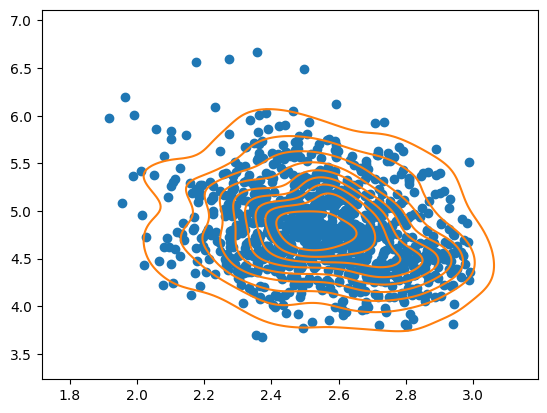

In [90]:
plt.scatter(np.log10(q[:,0]),q[:,1])
sns.kdeplot(np.log10(q[:,0]),q[:,1],color='C1')

In [91]:
from copy import deepcopy
p = deepcopy(df_NN[['Tau','Rho']]).to_numpy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


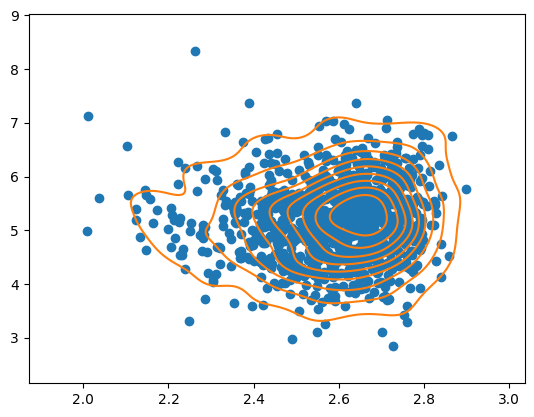

In [92]:
plt.scatter(np.log10(p[:,0]),p[:,1])
sns.kdeplot(np.log10(p[:,0]),p[:,1],color='C1')

In [129]:
from copy import deepcopy
p = deepcopy(df_NN_MLE[['Tau','Rho']]).to_numpy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


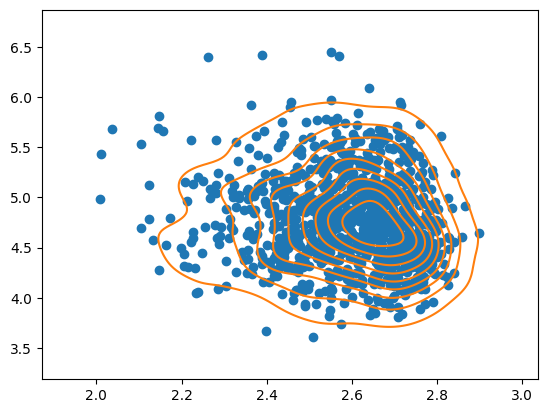

In [130]:
plt.scatter(np.log10(p[:,0]),p[:,1])
sns.kdeplot(np.log10(p[:,0]),p[:,1],color='C1')

In [ ]:
df_inference = pd.DataFrame()

In [162]:
def get_error(df):
  tau_pred = df['Tau'].to_numpy()
  tau_err = np.log10(tau_pred) - np.log10(tau)

  rho_pred = df['Rho'].to_numpy()
  rho_err = rho_pred - rho
  return np.array([tau_err,rho_err]).T

In [154]:
get_error(df_MLE).shape

(2, 1000)

In [229]:
errors = np.stack([get_error(df_MLE),get_error(df_NN),get_error(df_NN_MLE)])

In [164]:
errors.shape

(3, 1000, 2)

In [221]:
q = np.stack([np.nanmedian(np.abs(errors),axis=1),np.nanmean(np.abs(errors),axis=1),
                                      np.sqrt(np.nanmean(errors**2,axis=1))],axis=1)

In [177]:
np.nanmedian(np.abs(errors),axis=1)

array([[0.20688226, 0.31304503],
       [0.12241139, 0.5703112 ],
       [0.12241139, 0.3035083 ]])

In [178]:
np.nanmean(np.abs(errors),axis=1)

array([[0.24057522, 0.36858368],
       [0.15693784, 0.67015697],
       [0.15695971, 0.3544899 ]])

In [230]:
df_inference = pd.DataFrame(np.stack([np.nanmedian(np.abs(errors),axis=1),np.nanmean(np.abs(errors),axis=1),
                                      np.sqrt(np.nanmean(errors**2,axis=1))],axis=1).reshape(3,-1),
                            columns=['logTau_MAD','Rho_MAD','logTau_MAE','Rho_MAE','logTau_RMSE','Rho_RMSE'])
df_inference['Method'] = ['MLE','NN','NN_MLE']

In [231]:
df_inference.round(3)

,logTau_MAD,Rho_MAD,logTau_MAE,Rho_MAE,logTau_RMSE,Rho_RMSE,Method
0,0.207,0.313,0.241,0.369,0.318,0.464,MLE
1,0.122,0.570,0.157,0.670,0.205,0.834,NN
2,0.122,0.304,0.157,0.354,0.205,0.444,NN_MLE


array([3.57216595e+02, 4.78157168e+00, 9.93357793e-01, 4.99031617e-02,
       9.82493813e-02, 9.26839421e-03, 9.98069312e-01, 7.73748134e-03,
       1.44493131e-02, 3.13085702e-03, 9.79762861e-01, 1.20360743e-01,
       1.58861769e-01, 9.25650485e-02])

In [185]:
df_NN_MLE.median()

Tau          407.760112
Rho            4.749496
Chi2_full      0.992879
MAE_full       0.049838
MAD_full       0.098076
RMSE_full      0.009275
Chi2_obs       0.998096
MAE_obs        0.007727
MAD_obs        0.014455
RMSE_obs       0.003133
Chi2_gap       0.980729
MAE_gap        0.120604
MAD_gap        0.159144
RMSE_gap       0.092848
dtype: float64

In [232]:
df_interpolation = pd.DataFrame(np.array([df_DRW.mean().values[2:],df_DRW.median().values[2:],np.nanpercentile(df_DRW,50+68/2,axis=0)[2:]-np.nanpercentile(df_DRW,50,axis=0)[2:],
                                          np.nanpercentile(df_DRW,50,axis=0)[2:] - np.nanpercentile(df_DRW,50-68/2,axis=0)[2:],
    df_MLE.mean().values[2:],df_MLE.median().values[2:],np.nanpercentile(df_MLE,50+68/2,axis=0)[2:]-np.nanpercentile(df_MLE,50,axis=0)[2:],
                                          np.nanpercentile(df_MLE,50,axis=0)[2:] - np.nanpercentile(df_MLE,50-68/2,axis=0)[2:],
                                          df_NN_MLE.mean().values[2:],df_NN_MLE.median().values[2:],np.nanpercentile(df_NN_MLE,50+68/2,axis=0)[2:] - np.nanpercentile(df_NN_MLE,50,axis=0)[2:],
                                          np.nanpercentile(df_NN_MLE,50,axis=0)[2:] - np.nanpercentile(df_NN_MLE,50-68/2,axis=0)[2:]]),
                                columns = df_NN_MLE.columns[2:], 
                                index = ['DRW mean','DRW median','DRW upper sigma','DRW lower sigma',
                                         'MLE mean','MLE median','MLE upper sigma','MLE lower sigma','NN MLE mean','NN MLE median','NN MLE upper sigma','NN MLE lower sigma'])

In [233]:
df_interpolation

,Chi2_full,MAE_full,MAD_full,RMSE_full,Chi2_obs,MAE_obs,MAD_obs,RMSE_obs,Chi2_gap,MAE_gap,MAD_gap,RMSE_gap
DRW mean,1.261736,0.054568,0.104018,0.012382,0.345454,0.010751,0.021788,0.004306,2.809096,0.128406,0.167361,0.101685
DRW median,1.210945,0.052319,0.100364,0.011986,0.332631,0.009707,0.017700,0.004155,2.694680,0.123015,0.161081,0.097764
DRW upper sigma,0.362454,0.015783,0.029363,0.003389,0.062263,0.003385,0.007614,0.001119,0.921225,0.037501,0.046634,0.031233
DRW lower sigma,0.267096,0.011939,0.024596,0.002551,0.048728,0.002034,0.004078,0.000806,0.698370,0.027454,0.038152,0.022616
MLE mean,1.004886,0.052020,0.101706,0.009652,1.003007,0.008691,0.018688,0.003243,1.008372,0.125039,0.164116,0.097626
MLE median,0.993358,0.049903,0.098249,0.009268,0.998069,0.007737,0.014449,0.003131,0.979763,0.120361,0.158862,0.092565
MLE upper sigma,0.130949,0.015351,0.028803,0.002692,0.084873,0.002823,0.007425,0.000829,0.313167,0.035600,0.045724,0.031493
MLE lower sigma,0.110350,0.011581,0.023999,0.001964,0.078664,0.001652,0.003392,0.000621,0.252214,0.027516,0.037223,0.021013
NN MLE mean,1.004552,0.051945,0.101519,0.009646,1.002131,0.008692,0.018695,0.003242,1.008948,0.124858,0.163809,0.097507
NN MLE median,0.992879,0.049838,0.098076,0.009275,0.998096,0.007727,0.014455,0.003133,0.980729,0.120604,0.159144,0.092848


In [234]:
df_interpolation.loc[['DRW mean','MLE mean','NN MLE mean']]

,Chi2_full,MAE_full,MAD_full,RMSE_full,Chi2_obs,MAE_obs,MAD_obs,RMSE_obs,Chi2_gap,MAE_gap,MAD_gap,RMSE_gap
DRW mean,1.261736,0.054568,0.104018,0.012382,0.345454,0.010751,0.021788,0.004306,2.809096,0.128406,0.167361,0.101685
MLE mean,1.004886,0.052020,0.101706,0.009652,1.003007,0.008691,0.018688,0.003243,1.008372,0.125039,0.164116,0.097626
NN MLE mean,1.004552,0.051945,0.101519,0.009646,1.002131,0.008692,0.018695,0.003242,1.008948,0.124858,0.163809,0.097507


In [236]:
df_interpolation.loc[['DRW median','MLE median','NN MLE median']]

,Chi2_full,MAE_full,MAD_full,RMSE_full,Chi2_obs,MAE_obs,MAD_obs,RMSE_obs,Chi2_gap,MAE_gap,MAD_gap,RMSE_gap
DRW median,1.210945,0.052319,0.100364,0.011986,0.332631,0.009707,0.017700,0.004155,2.694680,0.123015,0.161081,0.097764
MLE median,0.993358,0.049903,0.098249,0.009268,0.998069,0.007737,0.014449,0.003131,0.979763,0.120361,0.158862,0.092565
NN MLE median,0.992879,0.049838,0.098076,0.009275,0.998096,0.007727,0.014455,0.003133,0.980729,0.120604,0.159144,0.092848


In [237]:
df_interpolation.loc[['DRW median','NN MLE median']].round(3)

,Chi2_full,MAE_full,MAD_full,RMSE_full,Chi2_obs,MAE_obs,MAD_obs,RMSE_obs,Chi2_gap,MAE_gap,MAD_gap,RMSE_gap
DRW median,1.211,0.052,0.100,0.012,0.333,0.010,0.018,0.004,2.695,0.123,0.161,0.098
NN MLE median,0.993,0.050,0.098,0.009,0.998,0.008,0.014,0.003,0.981,0.121,0.159,0.093


,0,1,2
0,0.0,182.783405,132.239888
1,0.0,0.006923,0.409066
2,0.0,0.006642,0.017394
3,0.0,0.049903,0.049781
4,0.0,0.098249,0.097922
5,0.0,0.009268,0.009305
6,0.0,0.001931,0.022304
7,0.0,0.007737,0.007725
8,0.0,0.014449,0.014450
9,0.0,0.003131,0.003133


In [116]:
q.shape

(3, 14)

In [112]:
np.array(q,dtype=np.float64)

array([[5.40000000e+02, 4.77464829e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.57216595e+02, 4.78157168e+00, 9.93357793e-01, 4.99031617e-02,
        9.82493813e-02, 9.26839421e-03, 9.98069312e-01, 7.73748134e-03,
        1.44493131e-02, 3.13085702e-03, 9.79762861e-01, 1.20360743e-01,
        1.58861769e-01, 9.25650485e-02],
       [4.07760112e+02, 5.18371415e+00, 9.82606408e-01, 4.97809840e-02,
        9.79217751e-02, 9.30495727e-03, 1.02230356e+00, 7.72547542e-03,
        1.44503224e-02, 3.13261853e-03, 9.07047772e-01, 1.20240909e-01,
        1.58905488e-01, 9.29880586e-02]])

In [98]:
df_NN.mean()

Tau          406.427668
Rho            5.184623
Chi2_full      0.995143
MAE_full       0.051953
MAD_full       0.101505
RMSE_full      0.009655
Chi2_obs       1.026366
MAE_obs        0.008693
MAD_obs        0.018692
RMSE_obs       0.003244
Chi2_gap       0.942941
MAE_gap        0.124867
MAD_gap        0.163778
RMSE_gap       0.097548
dtype: float64

In [ ]:
test_data = test_magnitude[test_mask]

In [ ]:
test_data = test_magnitude[test_mask]
NegLogLikelihood(test_time[test_mask]*365,test_data,np.ones_like(test_data)*np.sqrt(noise_variance),*result_MLE,Normalised=False)

DeviceArray(1129.46001598, dtype=float64)

In [ ]:
var_MLE[test_mask,test_mask]

array([0.01882308, 0.01623461, 0.013713  , ..., 0.00056051, 0.00137243,
       0.00253831])

In [ ]:
Low_triangular_Covariance = jax.scipy.linalg.cholesky(var_MLE, lower=True)

  # Euclidian Error estimation (self.y-mu*one).T @ inv_K @ (self.y-mu*one)
Squared_Error = (test_magnitude - mean_MLE).T @ (jax.scipy.linalg.cho_solve((Low_triangular_Covariance, True), test_magnitude - mean_MLE))
Chi_squared = Squared_Error / 2

LnDetCov = 2 * jnp.sum(jnp.log(jnp.diag(Low_triangular_Covariance)))

Normalisation = 0.5 * len(test_magnitude) * np.log(2*np.pi) + 0.5 * LnDetCov

NLL = Normalisation + Chi_squared

In [ ]:
NLL

DeviceArray(-14595.17891659, dtype=float64)

In [ ]:
Chi_squared

DeviceArray(1654.60402315, dtype=float64)

In [ ]:
Low_triangular_Covariance = jax.scipy.linalg.cholesky(var_NN + np.eye(len(var_NN))*noise_variance, lower=True)

  # Euclidian Error estimation (self.y-mu*one).T @ inv_K @ (self.y-mu*one)
Squared_Error = (test_magnitude - mean_NN).T @ (jax.scipy.linalg.cho_solve((Low_triangular_Covariance, True), test_magnitude - mean_NN))
Chi_squared = Squared_Error / 2

LnDetCov = 2 * jnp.sum(jnp.log(jnp.diag(Low_triangular_Covariance)))

Normalisation = 0.5 * len(test_magnitude) * np.log(2*np.pi) + 0.5 * LnDetCov

NLL = Normalisation + Chi_squared

In [ ]:
NLL

DeviceArray(1.55485194e+08, dtype=float64)

In [ ]:
Chi_squared

DeviceArray(1.55500629e+08, dtype=float64)

In [ ]:

        # Normalisation of multivariate gaussian distribution
        
        return Normalisation + Chi_squared

In [ ]:
df_MLE

,Chi2,MAE,MAD,RMSE
0,0.926179,0.015173,0.033636,0.004904
1,1.003873,0.024211,0.067811,0.006247
2,0.962621,0.016172,0.030024,0.006862
3,1.058875,0.012162,0.022790,0.005158
4,0.991331,0.013537,0.025989,0.005510
5,1.014883,0.030037,0.085398,0.006433
6,1.064833,0.045036,0.144843,0.006751
7,1.134422,0.010379,0.019649,0.004303
8,0.950686,0.019110,0.041896,0.006415
9,0.971733,0.012428,0.021337,0.005423


In [ ]:
compute_metrics(test_magnitude,test_mask,mean_MLE,var_MLE)

(1.0038728939789288,
 0.024210708955833344,
 0.06781057137651599,
 0.006247358283677673)

In [ ]:
compute_metrics(test_magnitude,test_mask,mean_NN,var_NN)

(0.9738413812726224,
 0.024492759224292813,
 0.06907818600891946,
 0.006246787220532346)

In [ ]:
compute_metrics(test_magnitude,~test_mask,mean_MLE,var_MLE)

(0.5765823451179097,
 0.1676395176396607,
 0.2297387221269329,
 0.12086055211478462)

In [ ]:
compute_metrics(test_magnitude,~test_mask,mean_NN,var_NN)

(0.6272271111892781,
 0.1729616635518299,
 0.23549904449222744,
 0.12864850634037692)

In [ ]:
compute_metrics(test_magnitude,np.ones_like(test_mask),mean_MLE,var_MLE)

(0.8514530872345323,
 0.0753735333137356,
 0.14759826142295815,
 0.015882773961330796)

In [ ]:
compute_metrics(test_magnitude,np.ones_like(test_mask),mean_NN,var_NN)

(0.850199797807276,
 0.0774534478364718,
 0.1511715310232567,
 0.016061510601114576)

In [ ]:
def compute_metrics(target_tensor,mean,std,region_mask=None):

    mask = ~np.isnan(target_tensor[:,0,1:])
    target = target_tensor[:,1,1:]
    nan_mask = np.ones_like(std)
    nan_mask[std==0] = np.nan

    if region_mask is not None:
        reg_mask = region_mask
    else:
        reg_mask = np.ones_like(mean)

    full_mask = mask*nan_mask*reg_mask

    chi2 = np.nanmean((((mean - target)/std)**2)*full_mask,axis=-1)
    mae = np.nanmean(np.abs(mean - target)*full_mask,axis=-1)
    mse = np.nanmean(((mean - target)**2)*full_mask,axis=-1)

    return chi2,mae,np.sqrt(mse)